In [49]:
import tensorflow as tf
from tensorflow import keras

if tf.test.gpu_device_name()=='':
    print('You do not have GPU access.')
    !nvidia-smi

else:
  print('You have GPU access')
  !nvidia-smi

# from tensorflow.python.client import device_lib 
# device_lib.list_local_devices()

# print the tensorflow version
print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))
tf.test.gpu_device_name()

You have GPU access
Fri Feb 25 16:40:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000       WDDM  | 00000000:91:00.0  On |                  Off |
| 26%   34C    P8     8W / 180W |  16311MiB / 16384MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

'/device:GPU:0'


|    0   N/A  N/A      8660    C+G   ...5n1h2txyewy\SearchApp.exe    N/A      |
|    0   N/A  N/A      9104    C+G   ...ekyb3d8bbwe\YourPhone.exe    N/A      |
|    0   N/A  N/A      9356    C+G   ...cw5n1h2txyewy\LockApp.exe    N/A      |
|    0   N/A  N/A     13092    C+G   ...zilla Firefox\firefox.exe    N/A      |
|    0   N/A  N/A     18452    C+G   ...ffice\program\soffice.bin    N/A      |
|    0   N/A  N/A     22240    C+G   ...bbwe\Microsoft.Photos.exe    N/A      |
|    0   N/A  N/A     22608    C+G   ...zilla Firefox\firefox.exe    N/A      |
|    0   N/A  N/A     28560    C+G   ...wekyb3d8bbwe\Video.UI.exe    N/A      |
|    0   N/A  N/A     30420    C+G   ...Fiji.app\ImageJ-win64.exe    N/A      |
|    0   N/A  N/A     55020      C   ...conda3\envs\tf\python.exe    N/A      |
|    0   N/A  N/A     65036    C+G   ...p-2.9.6\GitHubDesktop.exe    N/A      |
|    0   N/A  N/A     70488    C+G   ...kyb3d8bbwe\Calculator.exe    N/A      |
+--------------------------------------

In [50]:
from tensorflow.keras import layers
import os
import tifffile as tiff
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from tensorflow import keras


def patch_image(img, SIZE=288):
    #breaks up image to SIZExSIZE non-overlapping patches, returns reshaped array
    # img.shape = (2304, 2304)
    patches = patchify(img, patch_size=(SIZE, SIZE), step=(SIZE, SIZE))
    #patches.shape = (8, 8, 288, 288)

    #return.shape = (64, 288 ,288)
    return patches.reshape(patches.shape[0]*patches.shape[1], SIZE, SIZE, 1)

def patch_stack(img, SIZE=288, DEPTH=3, STRIDE=1):
    # breaks up image to SIZExSIZE non-overlapping patches, returns reshaped array
    # img.shape = (12, 2304, 2304)
    patches = patchify(img, patch_size=(DEPTH, SIZE, SIZE), step=(STRIDE, SIZE, SIZE))
    # patches.shape = (10, 8, 8, 3, 288, 288)

    # return.shape = (64, 3, 288 ,288)
    return patches.reshape(patches.shape[0] * patches.shape[1] * patches.shape[2], -1,  SIZE, SIZE)


# Normalization functions from Martin Weigert
def normalizePercentile(x, pmin=1, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """This function is adapted from Martin Weigert"""
    """Percentile-based image normalization."""

    mi = np.percentile(x, pmin, axis=axis, keepdims=True)
    ma = np.percentile(x, pmax, axis=axis, keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)


def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):  # dtype=np.float32
    """This function is adapted from Martin Weigert"""
    if dtype is not None:
        x = x.astype(dtype, copy=False)
        mi = dtype(mi) if np.isscalar(mi) else mi.astype(dtype, copy=False)
        ma = dtype(ma) if np.isscalar(ma) else ma.astype(dtype, copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x = (x - mi) / (ma - mi + eps)

    if clip:
        x = np.clip(x, 0, 1)

    return x


# Simple normalization to min/max fir the Mask
def normalizeMinMax(x, dtype=np.float32):
    x = x.astype(dtype, copy=False)
    x = (x - np.amin(x)) / (np.amax(x) - np.amin(x))
    return x

def checkEmptyMask(arr):
    #checks if any patches are without masks
    #returns list of indexes where mask is all zeros
    out = []
    for i in range(arr.shape[0]):
        if not arr[i].any():
            out.append(i)

    return out

In [51]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [4]:
train_path = r"Bactnet/Training data/stacks"

batch_size = 16
SIZE = 288
image_dataset = None
mask_dataset = None

def prepare_data(train_path, PATCH_SIZE):
    stacks = os.listdir(os.path.join(train_path, "training_source"))
    image_dataset = None
    mask_dataset = None
    for stack in stacks:
        if (stack.split(".")[-1]=="tif"):
            img = tiff.imread(os.path.join(train_path, "training_source",stack))
            mask = tiff.imread(os.path.join(train_path, "training_target", stack))

            img = patch_stack(img, PATCH_SIZE)
            mask =patch_stack(mask, PATCH_SIZE)
            mask = mask[:, 1, :, :].reshape((mask.shape[0], 1, mask.shape[2], -1))

            #print(stack, img.shape, mask.shape)
            mask = normalizeMinMax(mask)
            not_ok_idxs = checkEmptyMask(mask)
            mask = np.delete(mask, not_ok_idxs, axis=0)
            img = np.delete(img, not_ok_idxs, axis=0)

            img = normalizePercentile(img, 0.1, 99.9, clip=True)

            #print(stack, img.shape, mask.shape)

            if image_dataset is not None:
                image_dataset = np.concatenate((image_dataset, img))

            if mask_dataset is not None:
                mask_dataset = np.concatenate((mask_dataset, mask))

            if image_dataset is None:
                image_dataset = img

            if mask_dataset is None:
                mask_dataset = mask

            #print(image_dataset.shape, mask_dataset.shape)

    return image_dataset, mask_dataset






In [5]:
image_dataset, mask_dataset = prepare_data(train_path, SIZE)
print(image_dataset.shape, mask_dataset.shape)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.15, random_state = 8)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1072, 3, 288, 288) (1072, 1, 288, 288)
(911, 3, 288, 288) (161, 3, 288, 288) (911, 1, 288, 288) (161, 1, 288, 288)


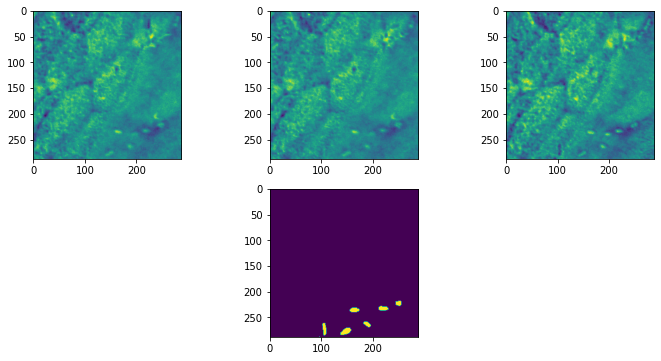

In [6]:
#Sanity check, view few mages
import random

image_number = random.randint(0, X_test.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(231)
plt.imshow(X_test[image_number, 0, :, :])
plt.subplot(232)
plt.imshow(X_test[image_number, 1, :, :])
plt.subplot(233)
plt.imshow(X_test[image_number, 2, :, :])
plt.subplot(235)
plt.imshow(y_test[image_number, 0, :, :])
plt.show()

###############################################################

In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    t = Conv2D(num_filters, 3, padding="same",  data_format="channels_first", activation='relu')(input)
    t = BatchNormalization()(t)
    t = Dropout(0.1)(t)
    t = Conv2D(num_filters, 3, padding="same",  data_format="channels_first", activation='relu')(t)
    t = BatchNormalization()(t)
    t = Dropout(0.1)(t)
    return t

#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2), data_format="channels_first")(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same", data_format="channels_first")(input)
    x = Concatenate(axis=1)([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid", data_format="channels_first")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [8]:
keras.backend.clear_session() # Free up RAM in case the model definition cells were run multiple times


#from keras_unet_collection import models
from keras_unet_collection import losses


# Build model
def hybrid_loss(y_true, y_pred):

    loss_focal = losses.focal_tversky(y_true, y_pred, alpha=0.5, gamma=4/3)
    loss_iou = losses.iou_seg(y_true, y_pred)
    
    # (x) 
    #loss_ssim = losses.ms_ssim(y_true, y_pred, max_val=1.0, filter_size=4)
    
    return loss_focal+loss_iou #+loss_ssim

SIZE=288
input_shape = (3, SIZE, SIZE)
batch_size = 8

model = build_unet(input_shape)
model.compile(loss=[hybrid_loss, hybrid_loss, hybrid_loss, hybrid_loss, hybrid_loss],
                  loss_weights=[0.25, 0.25, 0.25, 0.25, 1.0],
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=[losses.dice_coef, losses.iou_seg])
model.summary()
print(get_model_memory_usage(batch_size, model))


Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 288, 288) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 288, 288) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 288, 288) 1152        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 288, 288) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

(8, 3, 288, 288) (8, 1, 288, 288)


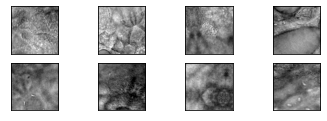

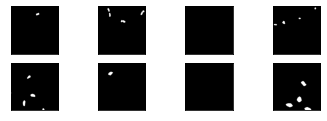

In [9]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=1337
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=180,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     data_format="channels_first")

mask_data_gen_args = dict(rotation_range=180,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     data_format="channels_first",
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
#image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) #Default batch size 32, if not specified here

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
#mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)  #Default batch size 32, if not specified here

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)


x = valid_img_generator.next()
y = valid_mask_generator.next()
print(x.shape, y.shape)
for i in range(len(x)):
    image = x[i]
    fig1 = plt.subplot(4, 4, i+1)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(image[1, :,:], cmap='gray')
    #plt.subplot(4,4,2)
    #plt.imshow(mask[0,:,:])
plt.show()

for i in range(len(x)):
    image = y[i]
    fig1 = plt.subplot(4, 4, i+1)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(image[0, :,:], cmap='gray')
    #plt.subplot(4,4,2)
    #plt.imshow(mask[0,:,:])
plt.show()


steps_per_epoch = 3*(len(X_train))//batch_size

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

epochs = 1000
#model.load_weights(r"/models/bactunet_3frame_local.hdf5")

#ModelCheckpoint callback saves a model at some interval.

filepath=r"models/bactunet_3frame_local_dice.hdf5" 
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for 10 consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger(r'models/bactnet_logs.csv', separator=',', append=True)

callbacks_list = [checkpoint, early_stop, log_csv]

#We can now use these generators to train our model. 
#Give this a name so we can call it later for plotting loss, accuracy etc. as a function of epochs.

history = model.fit(
        my_generator,
        steps_per_epoch=steps_per_epoch,   
        epochs=epochs,
        validation_data=validation_datagen,
        validation_steps=steps_per_epoch,
        callbacks=callbacks_list)

model.save(r"/models/bactunet_3frame_final_dice.hdf5") 

Epoch 1/1000
341/341 [==============================] - 276s 785ms/step - loss: 0.2513 - dice_coef: 0.6300 - iou_seg: 0.5336 - val_loss: 0.3299 - val_dice_coef: 0.4520 - val_iou_seg: 0.6953

Epoch 00001: val_loss improved from inf to 0.32994, saving model to models\bactunet_3frame_local_dice.hdf5
Epoch 2/1000
341/341 [==============================] - 265s 778ms/step - loss: 0.2514 - dice_coef: 0.6301 - iou_seg: 0.5339 - val_loss: 0.3172 - val_dice_coef: 0.4798 - val_iou_seg: 0.6695

Epoch 00002: val_loss improved from 0.32994 to 0.31716, saving model to models\bactunet_3frame_local_dice.hdf5
Epoch 3/1000
341/341 [==============================] - 264s 774ms/step - loss: 0.2475 - dice_coef: 0.6376 - iou_seg: 0.5255 - val_loss: 0.3775 - val_dice_coef: 0.3338 - val_iou_seg: 0.7869

Epoch 00003: val_loss did not improve from 0.31716
Epoch 4/1000
341/341 [==============================] - 264s 774ms/step - loss: 0.2527 - dice_coef: 0.6272 - iou_seg: 0.5364 - val_loss: 0.2732 - val_dice_coe

Epoch 33/1000
341/341 [==============================] - 259s 759ms/step - loss: 0.2340 - dice_coef: 0.6640 - iou_seg: 0.4973 - val_loss: 0.2577 - val_dice_coef: 0.6063 - val_iou_seg: 0.5526

Epoch 00033: val_loss did not improve from 0.24925
Epoch 34/1000
341/341 [==============================] - 258s 758ms/step - loss: 0.2329 - dice_coef: 0.6659 - iou_seg: 0.4948 - val_loss: 0.2609 - val_dice_coef: 0.6037 - val_iou_seg: 0.5548

Epoch 00034: val_loss did not improve from 0.24925
Epoch 35/1000
341/341 [==============================] - 259s 759ms/step - loss: 0.2357 - dice_coef: 0.6604 - iou_seg: 0.5007 - val_loss: 0.2572 - val_dice_coef: 0.6124 - val_iou_seg: 0.5487

Epoch 00035: val_loss did not improve from 0.24925
Epoch 36/1000
341/341 [==============================] - 258s 758ms/step - loss: 0.2342 - dice_coef: 0.6634 - iou_seg: 0.4976 - val_loss: 0.2564 - val_dice_coef: 0.6163 - val_iou_seg: 0.5439

Epoch 00036: val_loss did not improve from 0.24925
Epoch 37/1000
341/341 [=====

341/341 [==============================] - 258s 758ms/step - loss: 0.2159 - dice_coef: 0.6982 - iou_seg: 0.4588 - val_loss: 0.2342 - val_dice_coef: 0.6578 - val_iou_seg: 0.5004

Epoch 00098: val_loss did not improve from 0.23238
Epoch 99/1000
341/341 [==============================] - 258s 758ms/step - loss: 0.2132 - dice_coef: 0.7030 - iou_seg: 0.4530 - val_loss: 0.2368 - val_dice_coef: 0.6448 - val_iou_seg: 0.5122

Epoch 00099: val_loss did not improve from 0.23238
Epoch 100/1000
341/341 [==============================] - 259s 759ms/step - loss: 0.2127 - dice_coef: 0.7034 - iou_seg: 0.4515 - val_loss: 0.2400 - val_dice_coef: 0.6438 - val_iou_seg: 0.5152

Epoch 00100: val_loss did not improve from 0.23238
Epoch 101/1000
341/341 [==============================] - 259s 759ms/step - loss: 0.2137 - dice_coef: 0.7017 - iou_seg: 0.4537 - val_loss: 0.2295 - val_dice_coef: 0.6646 - val_iou_seg: 0.4926

Epoch 00101: val_loss improved from 0.23238 to 0.22954, saving model to models\bactunet_3fr


Epoch 00163: val_loss did not improve from 0.22493
Epoch 164/1000
341/341 [==============================] - 258s 758ms/step - loss: 0.2008 - dice_coef: 0.7259 - iou_seg: 0.4263 - val_loss: 0.2256 - val_dice_coef: 0.6779 - val_iou_seg: 0.4784

Epoch 00164: val_loss did not improve from 0.22493
Epoch 165/1000
341/341 [==============================] - 258s 758ms/step - loss: 0.1971 - dice_coef: 0.7320 - iou_seg: 0.4183 - val_loss: 0.2325 - val_dice_coef: 0.6553 - val_iou_seg: 0.5014

Epoch 00165: val_loss did not improve from 0.22493
Epoch 166/1000
341/341 [==============================] - 258s 758ms/step - loss: 0.1951 - dice_coef: 0.7359 - iou_seg: 0.4138 - val_loss: 0.2292 - val_dice_coef: 0.6654 - val_iou_seg: 0.4927

Epoch 00166: val_loss did not improve from 0.22493
Epoch 167/1000
341/341 [==============================] - 259s 759ms/step - loss: 0.1958 - dice_coef: 0.7346 - iou_seg: 0.4152 - val_loss: 0.2222 - val_dice_coef: 0.6794 - val_iou_seg: 0.4763

Epoch 00167: val_loss i

341/341 [==============================] - 258s 758ms/step - loss: 0.1926 - dice_coef: 0.7401 - iou_seg: 0.4085 - val_loss: 0.2281 - val_dice_coef: 0.6672 - val_iou_seg: 0.4882

Epoch 00197: val_loss did not improve from 0.22156
Epoch 198/1000
341/341 [==============================] - 258s 757ms/step - loss: 0.1900 - dice_coef: 0.7447 - iou_seg: 0.4028 - val_loss: 0.2232 - val_dice_coef: 0.6786 - val_iou_seg: 0.4773

Epoch 00198: val_loss did not improve from 0.22156
Epoch 199/1000
341/341 [==============================] - 258s 758ms/step - loss: 0.1880 - dice_coef: 0.7486 - iou_seg: 0.3984 - val_loss: 0.2236 - val_dice_coef: 0.6761 - val_iou_seg: 0.4797

Epoch 00199: val_loss did not improve from 0.22156
Epoch 200/1000
341/341 [==============================] - 258s 758ms/step - loss: 0.1902 - dice_coef: 0.7445 - iou_seg: 0.4034 - val_loss: 0.2329 - val_dice_coef: 0.6610 - val_iou_seg: 0.4979

Epoch 00200: val_loss did not improve from 0.22156
Epoch 201/1000
341/341 [===============


Epoch 00230: val_loss did not improve from 0.22156
Epoch 231/1000
341/341 [==============================] - 271s 795ms/step - loss: 0.1862 - dice_coef: 0.7512 - iou_seg: 0.3947 - val_loss: 0.2245 - val_dice_coef: 0.6702 - val_iou_seg: 0.4847

Epoch 00231: val_loss did not improve from 0.22156
Epoch 232/1000
341/341 [==============================] - 269s 789ms/step - loss: 0.1794 - dice_coef: 0.7633 - iou_seg: 0.3797 - val_loss: 0.2314 - val_dice_coef: 0.6584 - val_iou_seg: 0.4980

Epoch 00232: val_loss did not improve from 0.22156
Epoch 233/1000
341/341 [==============================] - 274s 805ms/step - loss: 0.1829 - dice_coef: 0.7572 - iou_seg: 0.3874 - val_loss: 0.2262 - val_dice_coef: 0.6686 - val_iou_seg: 0.4867

Epoch 00233: val_loss did not improve from 0.22156
Epoch 234/1000
341/341 [==============================] - 271s 796ms/step - loss: 0.1846 - dice_coef: 0.7542 - iou_seg: 0.3910 - val_loss: 0.2347 - val_dice_coef: 0.6560 - val_iou_seg: 0.5015

Epoch 00234: val_loss d


Epoch 00263: val_loss did not improve from 0.21735
Epoch 264/1000
341/341 [==============================] - 269s 788ms/step - loss: 0.1766 - dice_coef: 0.7678 - iou_seg: 0.3736 - val_loss: 0.2229 - val_dice_coef: 0.6763 - val_iou_seg: 0.4785

Epoch 00264: val_loss did not improve from 0.21735
Epoch 265/1000
341/341 [==============================] - 260s 764ms/step - loss: 0.1806 - dice_coef: 0.7610 - iou_seg: 0.3824 - val_loss: 0.2305 - val_dice_coef: 0.6648 - val_iou_seg: 0.4937

Epoch 00265: val_loss did not improve from 0.21735
Epoch 266/1000
341/341 [==============================] - 268s 785ms/step - loss: 0.1789 - dice_coef: 0.7641 - iou_seg: 0.3787 - val_loss: 0.2199 - val_dice_coef: 0.6900 - val_iou_seg: 0.4658

Epoch 00266: val_loss did not improve from 0.21735
Epoch 267/1000
341/341 [==============================] - 263s 772ms/step - loss: 0.1830 - dice_coef: 0.7572 - iou_seg: 0.3876 - val_loss: 0.2184 - val_dice_coef: 0.6888 - val_iou_seg: 0.4666

Epoch 00267: val_loss d

341/341 [==============================] - 268s 785ms/step - loss: 0.1726 - dice_coef: 0.7745 - iou_seg: 0.3648 - val_loss: 0.2273 - val_dice_coef: 0.6704 - val_iou_seg: 0.4870

Epoch 00297: val_loss did not improve from 0.21735
Epoch 298/1000
341/341 [==============================] - 263s 771ms/step - loss: 0.1756 - dice_coef: 0.7693 - iou_seg: 0.3712 - val_loss: 0.2238 - val_dice_coef: 0.6803 - val_iou_seg: 0.4762

Epoch 00298: val_loss did not improve from 0.21735
Epoch 299/1000
341/341 [==============================] - 263s 772ms/step - loss: 0.1735 - dice_coef: 0.7730 - iou_seg: 0.3668 - val_loss: 0.2179 - val_dice_coef: 0.6915 - val_iou_seg: 0.4634

Epoch 00299: val_loss did not improve from 0.21735
Epoch 300/1000
341/341 [==============================] - 262s 769ms/step - loss: 0.1734 - dice_coef: 0.7732 - iou_seg: 0.3667 - val_loss: 0.2225 - val_dice_coef: 0.6753 - val_iou_seg: 0.4790

Epoch 00300: val_loss did not improve from 0.21735
Epoch 301/1000
341/341 [===============

In [10]:
model.load_weights(r"models/bactunet_3frame_local_dice.hdf5")

IoU socre is:  0.0072 Dice coeff is:  0 at threshold:  0.0
IoU socre is:  0.5253 Dice coeff is:  0 at threshold:  0.1
IoU socre is:  0.5257 Dice coeff is:  0 at threshold:  0.2
IoU socre is:  0.526 Dice coeff is:  0 at threshold:  0.3
IoU socre is:  0.5262 Dice coeff is:  0 at threshold:  0.4
IoU socre is:  0.5264 Dice coeff is:  0 at threshold:  0.5
IoU socre is:  0.5265 Dice coeff is:  0 at threshold:  0.6
IoU socre is:  0.5267 Dice coeff is:  0 at threshold:  0.7
IoU socre is:  0.5269 Dice coeff is:  0 at threshold:  0.8
IoU socre is:  0.5272 Dice coeff is:  0 at threshold:  0.9
IoU socre is:  0.0 Dice coeff is:  0 at threshold:  1.0


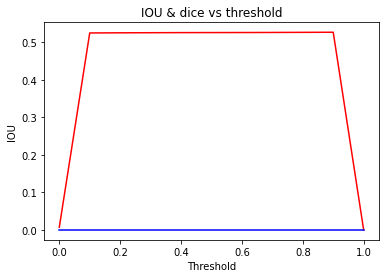

In [17]:
# ##################################
# #IOU
y_pred = model.predict(X_test)
IOUs = []
dices = []
thresh = []

for threshold in range(0, 11):
  threshold = threshold/10
  y_pred_thresholded = y_pred > threshold
  intersection = np.logical_and(y_test, y_pred_thresholded)
  union = np.logical_or(y_test, y_pred_thresholded)
  iou_score = np.sum(intersection) / np.sum(union)
  dice_c = 0#losses.dice_coef(y_test, y_pred)
  print("IoU socre is: ", round(iou_score, 4), "Dice coeff is: ", round(dice_c, 4),"at threshold: ", threshold)
  IOUs.append(iou_score)
  thresh.append(threshold)
  dices.append(dice_c)

#plot IOUs vs threshold
plt.plot(thresh, IOUs, 'r', label='IOU')
plt.plot(thresh, dices, 'b', label='Dice coeff')
plt.title('IOU & dice vs threshold')
plt.xlabel('Threshold')
plt.ylabel('IOU')
plt.show()

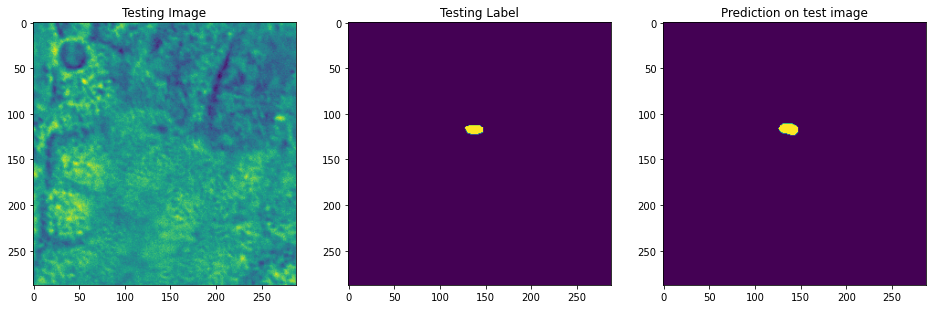

In [23]:
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')  #Trained for 50 epochs¨
#import pickle
#with open("/content/gdrive/MyDrive/Colab Notebooks/BT0403/model_folder/bactunet_3frame_25ep_history") as fh:
#    history = pickle.load(fh)

idx=random.randint(0, (len(X_test)))

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(X_test[idx, 1, :, : ])
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(y_test[idx, 0, : , :])
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(y_pred[idx, 0, :, :])

plt.show()

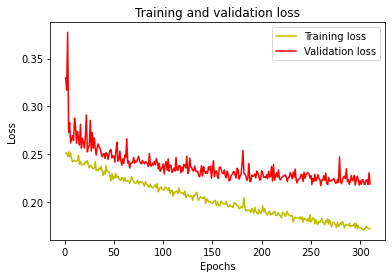

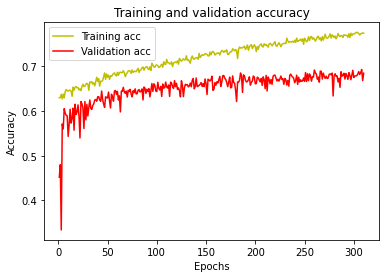

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
import math 
from patchify import unpatchify

#######
#THERE IS A BUG HERE!!! FIX PREDICTION AND UNPATCHING


def _createOutArr(shape, nrows, ncols, nchannels):
    out_height = int(nrows * shape[-2])
    out_width = int(ncols * shape[-1])
    out_frames = int(shape[0] / (nrows * ncols))
    outshape = (out_frames, nchannels, out_height, out_width)
    out_arr = np.empty(outshape, dtype=np.float32)

    return out_arr

def unpatcher(arr, nrows, ncols, nchannels=1):
    out_arr = _createOutArr(arr.shape, nrows, ncols, nchannels)
    patch_h = arr.shape[-2]
    patch_w = arr.shape[-1]
    n = 0
    for frame in range(out_arr.shape[0]):
        for i in range(nrows):
            for j in range(ncols):
                y = patch_h * i
                x = patch_w * j
                out_arr[frame, :, y:y+patch_h, x:x+patch_w] = arr[n]
                n += 1

    return out_arr

#load unseen data

validation_image_directory = r"C:\Users\analyst\Documents\Python Scripts\BactUnet\Bactnet\Training data\stacks\predict"
result_folder = r"C:\Users\analyst\Documents\Python Scripts\BactUnet\_results"

val_image_dataset = []
val_mask_dataset = []
pred_mask_dataset = []

images = os.listdir(validation_image_directory)

for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        
        image = tiff.imread(os.path.join(validation_image_directory, image_name))
        original_shape = image.shape
        patch = patch_stack(image, SIZE)
        
        patch = normalizePercentile(patch, 0.1, 99.9, clip=True)
        pred_mask_patch = model.predict(patch)
        print(image_name, original_shape, patch.shape, pred_mask_patch.shape)
        #pred_mask_patch = pred_mask_patch[:, 0, :,:]
        image = np.expand_dims(patch[:, 1, :,:], axis=1)
        patch = np.concatenate((image, pred_mask_patch), axis=1)
        unpatched = unpatcher(patch, 8, 8, 2)
        print(patch.shape)
        tiff.imwrite(os.path.join(result_folder, image_name), unpatched, imagej=True, resolution=(1./2.6755, 1./2.6755),
                      metadata={'unit': 'um', 'finterval': 15,
                                'axes': 'TCYX'})
        
        #pred_mask = unpatch_stack(pred_mask_patch, original_shape)
        #tiff.imsave(os.path.join(result_folder, image_name), pred_mask_patch)
        #val_image_dataset.append(image)
        #pred_mask_dataset.append(pred_mask)

BT0398_210.tif (11, 2304, 2304) (576, 3, 288, 288) (576, 1, 288, 288)
(576, 2, 288, 288)
BT403_013.tif (12, 2304, 2304) (640, 3, 288, 288) (640, 1, 288, 288)
(640, 2, 288, 288)
BT403_216.tif (12, 2304, 2304) (640, 3, 288, 288) (640, 1, 288, 288)
(640, 2, 288, 288)
BT404_001.tif (12, 2304, 2304) (640, 3, 288, 288) (640, 1, 288, 288)
(640, 2, 288, 288)


In [48]:
#Let's try a full movie

image_directory = r"C:\Users\analyst\Documents\Python Scripts\BactUnet\Bactnet\BT404_ENRRT_wt"
fname = "BT404_ENR+RT_wt.tif"
result_folder = r"C:\Users\analyst\Documents\Python Scripts\BactUnet\_results\BT404"

loadme = os.path.join(image_directory, fname)
image = tiff.imread(loadme)
original_shape = image.shape
patch = patch_stack(image, SIZE)
print(original_shape, patch.shape)

#split into smaller predictions
patchlist = np.split(patch, 238)
print(patchlist[0].shape)
for i, p in enumerate(patchlist):
    p = normalizePercentile(p, 0.1, 99.9, clip=True)
    pred_mask_patch = model.predict(p)
    unpatched = unpatcher(pred_mask_patch, 8, 8, 1)
    #unpatched = unpatched.astype('uint8')
    savename = "BT404_" + str(i+1) + ".tif"
    print(savename, unpatched.shape)
    tiff.imwrite(os.path.join(result_folder, savename), unpatched, imagej=True, resolution=(1./2.6755, 1./2.6755),
                 metadata={'unit': 'um', 'finterval': 15, 'axes': 'TCYX'})

(240, 2304, 2304) (15232, 3, 288, 288)
(64, 3, 288, 288)
BT404_1.tif (1, 1, 2304, 2304)
BT404_2.tif (1, 1, 2304, 2304)
BT404_3.tif (1, 1, 2304, 2304)
BT404_4.tif (1, 1, 2304, 2304)
BT404_5.tif (1, 1, 2304, 2304)
BT404_6.tif (1, 1, 2304, 2304)
BT404_7.tif (1, 1, 2304, 2304)
BT404_8.tif (1, 1, 2304, 2304)
BT404_9.tif (1, 1, 2304, 2304)
BT404_10.tif (1, 1, 2304, 2304)
BT404_11.tif (1, 1, 2304, 2304)
BT404_12.tif (1, 1, 2304, 2304)
BT404_13.tif (1, 1, 2304, 2304)
BT404_14.tif (1, 1, 2304, 2304)
BT404_15.tif (1, 1, 2304, 2304)
BT404_16.tif (1, 1, 2304, 2304)
BT404_17.tif (1, 1, 2304, 2304)
BT404_18.tif (1, 1, 2304, 2304)
BT404_19.tif (1, 1, 2304, 2304)
BT404_20.tif (1, 1, 2304, 2304)
BT404_21.tif (1, 1, 2304, 2304)
BT404_22.tif (1, 1, 2304, 2304)
BT404_23.tif (1, 1, 2304, 2304)
BT404_24.tif (1, 1, 2304, 2304)
BT404_25.tif (1, 1, 2304, 2304)
BT404_26.tif (1, 1, 2304, 2304)
BT404_27.tif (1, 1, 2304, 2304)
BT404_28.tif (1, 1, 2304, 2304)
BT404_29.tif (1, 1, 2304, 2304)
BT404_30.tif (1, 1, 2304

1 conv2d (3, 3, 3, 64)
4 conv2d_1 (3, 3, 64, 64)
8 conv2d_2 (3, 3, 64, 128)
11 conv2d_3 (3, 3, 128, 128)
15 conv2d_4 (3, 3, 128, 256)
18 conv2d_5 (3, 3, 256, 256)
22 conv2d_6 (3, 3, 256, 512)
25 conv2d_7 (3, 3, 512, 512)
29 conv2d_8 (3, 3, 512, 1024)
32 conv2d_9 (3, 3, 1024, 1024)
35 conv2d_transpose (2, 2, 512, 1024)
37 conv2d_10 (3, 3, 1024, 512)
40 conv2d_11 (3, 3, 512, 512)
43 conv2d_transpose_1 (2, 2, 256, 512)
45 conv2d_12 (3, 3, 512, 256)
48 conv2d_13 (3, 3, 256, 256)
51 conv2d_transpose_2 (2, 2, 128, 256)
53 conv2d_14 (3, 3, 256, 128)
56 conv2d_15 (3, 3, 128, 128)
59 conv2d_transpose_3 (2, 2, 64, 128)
61 conv2d_16 (3, 3, 128, 64)
64 conv2d_17 (3, 3, 64, 64)
67 conv2d_18 (1, 1, 64, 1)


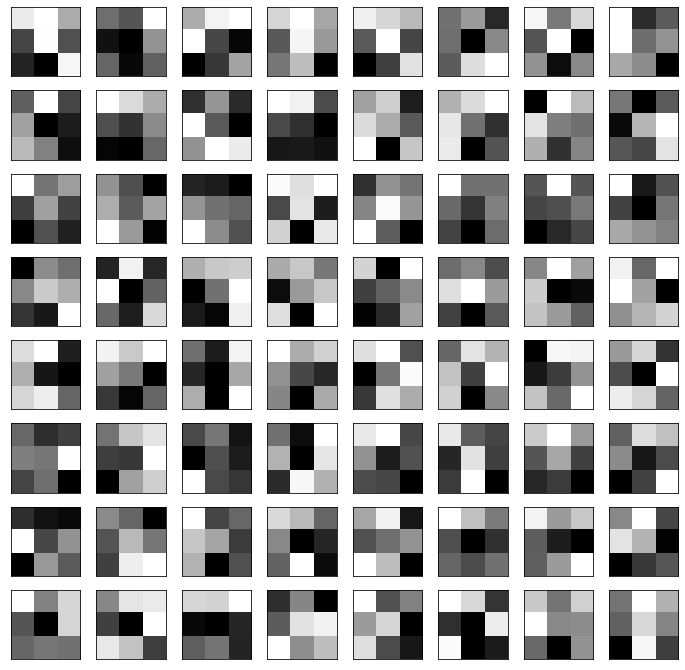

In [27]:
for i, layer in enumerate(model.layers):
  if "onv" in layer.name:
    print(i, layer.name, model.layers[i].get_weights()[0].shape)

weights, biases =  model.layers[4].get_weights()
fig1=plt.figure(figsize=(12, 12))


columns = 8 
rows = 8 
n_filters = columns*rows
for i in range(1, n_filters +1):
    f = weights[:, :, (i-1), 0]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])

    #plt.imshow(f[i%3, :, :], cmap='gray')
    plt.imshow(f[:, :], cmap='gray')
    #plt.imshow(f[2, :, :], cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
plt.show() 